## Transportation Problem example

This notebook contains a simple example of setting up and solving a transportation problem. 

## Background

The book defines a Transportation Problem as "in its general form, can be defined as the problem of transporting goods from a set of sources ($s \in \mathcal{S}$) to a set of destinations ($d \in \mathcal{D}$) in a way that satisfies both the supply and demand requirements of the different stakeholders while minimizing the overall transportation costs. For instance, think about transportation systems (a set of roads, inland-water connections, airline connections, etc.), pipelines (e.g., water supply systems) and power grids.

 Given such a setting, we can define $C_{s,d}$ the transportation cost (per unit) from source $s$ to destination $d$. In addition, we can define $S_s$ as the supply (amount of goods produced) of source $s$ and, in a similar fashion, $D_d$ as the demand (amount of goods received) of destination $d$. Finally, we only need one set of decision variables $x_{s,d}$ (generally speaking, continuous) that define the flow of goods from source $s$ to destination $d$.

For instance, suppose there is a set of warehouses $\mathcal{S}$, which having a capacity $s_i$, a set of stores $\mathcal{D}$, each having a demand of $d_i$ and $C_{s,d}$ the cost (per unit) to deliver the goods from a warehouse $s \in \mathcal{S}$ to a store $d \in \mathcal{D}$, just as in the figure below.

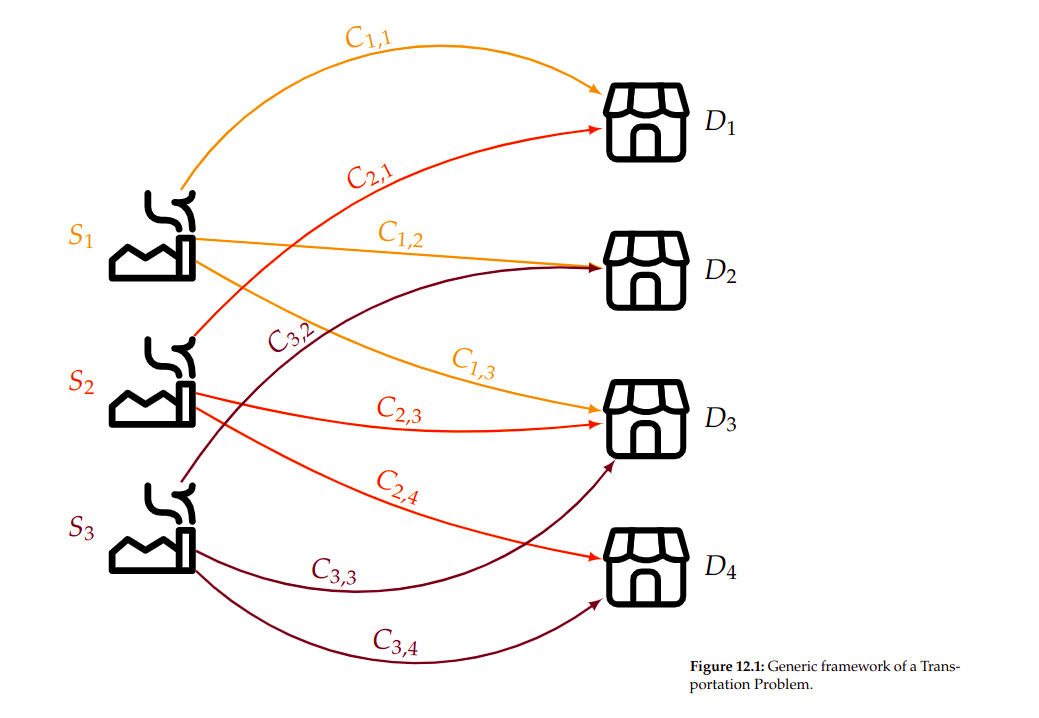

The goal is to determine the optimal (in this way, cheapest) way to deliver goods from the warehouses to the stores. However, there are some limitations (=constraints) to this problem, for instance a warehouse can not send more products than its capacity. 

## Dependencies

$\rightarrow$ Make sure that you have installed the packages bellow in your environment. If you're unsure that you have, run `pip list [--local]` or `conda list` (if you use conda) in your terminal to check which packages are installed and use `pip install [package name]` or `conda install [package name]` to install new packages.

In [1]:
import numpy as np
import pandas as pd
import os
import igraph as ig
import random
from gurobipy import Model,GRB,LinExpr,quicksum

Before starting, we shall define a random seed for reproducibility. If you're unfamiliar with this, please see for instance https://www.w3schools.com/python/ref_random_seed.asp

In [2]:
random.seed(42)

Define sets of sources and destinations

To model the sources and destinations, we will define a function taking the desired number of sources and number of destinations, and outputs two lists containing the indeces of these two sets. 

$\textbf{Note}$: We make use of Python's list comprehension to generate the source and destination's indexes. If you're not familiar with it, see for instance: https://www.w3schools.com/python/python_lists_comprehension.asp

In [3]:
def define_source_available_sources_destinations(nb_sources : int, nb_destinations : int):
    """
    Define source and destination lists based on the given number of sources and destinations.

    Parameters:
    - nb_sources (int): The number of sources.
    - nb_destinations (int): The number of destinations.

    Returns:
    - tuple: A tuple containing two lists:
        - sources (list): A list of source indices ranging from 1 to nb_sources.
        - destinations (list): A list of destination indices ranging from 1 to nb_destinations.

    Note: Python indexing starts from 0, but this function uses indices starting from 1.
    """
    sources = [source for source in range(1, nb_sources + 1)]
    destinations = [destination for destination in range(1, nb_destinations + 1)]
    
    return sources, destinations


sources, destinations = define_source_available_sources_destinations(nb_sources=3, nb_destinations=4)

Define supper_boundsets available_sources and accesable_deposits. Referring back to the figure, the value corresponding to key 1 in the dictionary is a list with the deposits where goods from deposit 1 can be send. For instance, deposit 1 can send goods to stores 1,2 and 3, but not to deposit 4. For more information on Python dictionaries see for instance https://www.w3schools.com/python/python_dictionaries.asp

In [4]:
accessable_deposits = {1:[1,2,3],
       2:[1,3,4],
       3:[2,3,4]}

available_sources = {1:[1,2],
       2:[1,3],
       3:[1,2,3],
       4:[2,3]} 

Define all parameters neededby the model, namely:
 - bounds on minimum supply $S_s^{-}$, maximum supply $S_s^{-}$, demand per source/destination $D_d^{-}$ and $D_d^{+}$
 - transportation cost per unit of each available edge $C_{s,d}$

In [5]:
minimum_supply = {1:10,2:10,3:10}
maximum_supply  = {1:50,2:80,3:60}
minimum_demand = {1:50,2:10,3:70,4:10}
maximum_demand  = {1:50,2:40,3:70,4:50}

For transportation costs, we randomly generate an integer number for the possible connections. Note that a dictionary can be defined also manually for custom use 

In [6]:
lower_bound = 10
upper_bound = 20
C_sd    = {(source, destination):random.randint(lower_bound,upper_bound) 
           for source in sources for destination in accessable_deposits[source]}  

## Define transportation problem MILP

First step is setup the model by creating the Model object 

In [7]:
model = Model() 

Set parameter Username

--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only - expires 2023-11-24


The second step is to add the decision variables. An important step is to decide the type of the variables (in this case, continous), and the lower and upper bound they can take. 

In [8]:
# Define continuous decision variables representing the quantity of goods from sources to accessible deposits.

#   Note:
#   The decision variables are added to the provided optimization model.
#   The lower bound of each variable is set to 0, and the upper bound is determined by the minimum of maximum supply and demand.

x = {}  # Dictionary to store continuous decision variables

# Iterate through each source and its accessible deposits
for s in sources:
    for d in accessable_deposits[s]:
        # Determine lower and upper bounds for the decision variable
        lower_bound_var = 0
        upper_bound_var = min(maximum_supply[s], maximum_demand[d])

        # Add continuous decision variable to the model
        x[s, d] = model.addVar(lb=lower_bound_var, ub=upper_bound_var,
                                vtype=GRB.CONTINUOUS, name="x[%s,%s]" % (s, d))

# Update the optimization model after adding all variables
model.update()


## Constraints

In order to ensure that the solution satisfies our requirements, we need to specify the constrains. The constraints needed are:

1. First constraint shall ensure that each source delivers goods within its capabilities

2. Second constraint shall ensure that each destination receives goods within its specified interval

3. The continuous nature of each decision variable. Also, due to the capacity bounds on sources 𝑠 ∈ S and destinations 𝑑 ∈ D, each $x_{s,d}$ cannot exceed the minimum between the maximum capacity that source 𝑠 can produce or destination $d$ can accommodate 

$\begin{array}{ll}
S_s^{-} \leq \sum_{d \in \mathcal{D}_s} x_{s, d} \leq S_s^{+} & \forall s \in \mathcal{S} \\
D_d^{-} \leq \sum_{s \in \mathcal{S}_d} x_{s, d} \leq D_d^{+} & \forall d \in \mathcal{D} \\
x_{s, d} \in\left[0, \min \left\{S_s^{+}, D_d^{+}\right\}\right] & \forall s \in \mathcal{S}, d \in \mathcal{D}_s
\end{array}$

In [9]:
# implementing the first constraint, in two steps (one for each inequality)
C1 = model.addConstrs((quicksum(x[s,d] for d in accessable_deposits[s])>=minimum_supply[s]
                       for s in sources), name="C1")
C2 = model.addConstrs((quicksum(x[s,d] for d in accessable_deposits[s])<=maximum_supply[s]
                       for s in sources), name="C2")

# implementing the second constrains, in two steps (one for each inequality)
C3 = model.addConstrs((quicksum(x[s,d] for s in available_sources[d])>=minimum_demand[d]
                       for d in destinations), name="C3")
C4 = model.addConstrs((quicksum(x[s,d] for s in available_sources[d])<=maximum_demand[d]
                       for d in destinations), name="C4")

The $\textbf{objective}$ can be formulated as:


 $\min \sum_{s \in \mathcal{S}} \sum_{d \in \mathcal{D}_s} C_{s, d} x_{s, d}$

 In plain words, we try to minimise the transportation costs from all sources to all destinations that each source can serve

In [10]:
obj = LinExpr() # ensure the objective is linear
                # check: https://www.gurobi.com/documentation/current/refman/py_lex.html

# for each source, take each possible path to a deposit and multiply its cost/unit with the number of
# objects sent on the route to determine the total cost
for s in sources:
    for d in accessable_deposits[s]:
        obj += C_sd[(s,d)]*x[s,d]

# tell Gurobi we try to minimise this objective
model.setObjective(obj,GRB.MINIMIZE)

Now, we can solve the MILP:

In [11]:
# Update the model before optimization. This may involve incorporating changes to the model.
model.update()

# Write the current state of the model to a file named "TP_original.lp" in LP format.
model.write("TP_original.lp")

# Set the MIPGap parameter to 0.001. This parameter controls the tolerance for the MIP (Mixed Integer Programming) solver.
model.setParam('MIPGap', 0.001)

# Set the TimeLimit parameter to 2 hours (2 * 3600 seconds). This restricts the optimization time to 2 hours.
model.setParam('TimeLimit', 2 * 3600)

# Set the LogFile parameter to "TP_original.log". This specifies the name of the file where the solver log will be written.
model.setParam("LogFile", "TP_original.log")

# Optimize the model. This command triggers the solver to find the optimal solution based on the given parameters and model.
model.optimize()


Set parameter MIPGap to value 0.001
Set parameter TimeLimit to value 7200
Set parameter LogFile to value "TP_original.log"
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 14 rows, 9 columns and 36 nonzeros
Model fingerprint: 0x919e45d0
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+01, 2e+01]
  Bounds range     [4e+01, 7e+01]
  RHS range        [1e+01, 8e+01]
Presolve removed 8 rows and 1 columns
Presolve time: 0.00s
Presolved: 6 rows, 13 columns, 21 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.4000000e+03   8.750000e+00   0.000000e+00      0s
       4    1.6700000e+03   0.000000e+00   0.000000e+00      0s

Solved in 4 iterations and 0.01 seconds (0.00 work units)
Optimal objective  1.670000000e+03


-Analyze solution

In [12]:
# Initialize an empty list to store the solution, where each element is a variable and its corresponding value.
solution = []

# Retrieve variable names and values from the optimization model.
for v in model.getVars():
    solution.append([v.varName, v.x])

# Set a small threshold (epsilon) to consider variables as active.
eps = 0.00001

# Initialize a list to store active routing variables based on the given threshold.
active_variables = []

# Iterate through the solution and identify variables with values greater than or equal to the epsilon threshold.
for i in range(0, len(solution)):
    if solution[i][1] >= eps:
        active_variables.append([solution[i][0], solution[i][1]])